# 基础因子加alpha191回测结果

添加费后曲线

In [1]:
%matplotlib inline
import sys
sys.path.append('../')
sys.path.append('../../')
sys.path.append('../../../')
import pandas as pd
from PyFin.api import *
from alphamind.api import *
from src.conf.models import *
from datetime import datetime, timedelta
import sqlite3
import numpy as np
from alphamind.execution.naiveexecutor import NaiveExecutor
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")
#显示所有列
pd.set_option('display.max_columns', None)
#显示所有行
pd.set_option('display.max_rows', None)
#设置value的显示长度为100，默认为50
pd.set_option('max_colwidth',100)


### 导入调仓记录

In [2]:
con = sqlite3.connect('./tune_record.db')
sql = 'select * from tune_record__whole_loose' # 回测时间: 2010-01~2019-10, 组合优化条件较松
# sql = 'select * from tune_record_strict' # 回测时间: 2017-01~2019-10, 组合优化条件严格, 
# sql = 'select * from tune_record_loose' # 回测时间: 2010-01~2019-10, 组合优化条件严格

tune_record = pd.read_sql(sql, con)

## 回测参数设置


In [3]:
# 资金总量
total_funds = 10000000

In [4]:
 ##--------------因子组合回测--------------
import json
import pdb
from rqalpha.api import *
from rqalpha import run_func
class DailyDefaultStrategy(object):
    def __init__(self, session, stock_sets_ob):
        self._stock_sets_ob = json.loads(stock_sets_ob)
        self._session = session
        self._start_time_str = datetime.now().strftime('%m-%d %H:%M')
    
    
    def init(self,context):
        #读取股票池文件
        context.stock_sets = pd.DataFrame(self._stock_sets_ob)
        context.trade_date_list= list(set(context.stock_sets.trade_date))
        context.holding_stock_df = None
        
        # 是否已发送了order
        context.fired = False

    #盘前处理
    def before_trading(self, context, bar_dict):
        context.trade_signal = False
        date = context.now.date()
        if str(date) in context.trade_date_list:
            context.trade_signal = True

    #盘后处理
    def after_trading(self, context):
        pass
    
    # 你选择的证券的数据更新将会触发此段逻辑，例如日或分钟历史数据切片或者是实时数据切片更新
    def handle_bar(self, context, bar_dict):
        # 开始编写你的主要的算法逻辑
        if context.trade_signal == False:
            return
        date = context.now.date()
        # stock_dict = context.stock_sets.set_index('trade_date').loc[str(date)]
        stock_set = context.stock_sets
        stock_dict = stock_set[stock_set['trade_date'] == str(date)].set_index('trade_date')
        stock_df = self.filter_specials(stock_dict, context)
        #剔除后的股票
        if 'portfolio_weight' in list(set(stock_df.columns)):
            self.rebalance_weight(context, stock_df)
        else:
            self.rebalance_equal(context, stock_df)
   
    def _industry_distribute(self, stock_positions, industries):
        industry_sets_dict = {}
        industries = industries.rename(columns={'symbol':'code'})
        stock_positions = stock_positions.reset_index().rename(
            columns={'symbol':'name','order_book_id':'code','date':'trade_date'})
        stock_positions['trade_date'] = stock_positions['trade_date'].apply(lambda x: x.strftime('%Y-%m-%d'))
        industries['trade_date'] = industries['trade_date'].apply(lambda x: x.strftime('%Y-%m-%d'))
        stock_positions = stock_positions.merge(industries, on=['trade_date','code'])
        industry_grouped = stock_positions.dropna().groupby(['trade_date'])
        for k, g in industry_grouped:
            gt = g.groupby(['industry_code','industry']).count().reset_index()[['industry_code','industry','code']]
            gt['ratio'] = gt['code']/gt['code'].values.sum()
            gt=gt.rename(columns={'industry':'industry_name'})
            industry_sets_dict[k] = gt[['industry_code','industry_name','ratio']].to_dict(orient='records')
        return industry_sets_dict
    
    def _month_profit(self, portfolio, stock_capital):
        pd.DataFrame(portfolio.reset_index()).shift(1)
        month_profit = portfolio['total_value'].resample('M').mean()
        month_profit = pd.DataFrame(month_profit.reset_index())
        month_profit['last_total'] = month_profit['total_value'].shift(1)
        month_profit = month_profit.fillna(stock_capital)
        month_profit['month_ratio'] = np.log(month_profit.total_value / month_profit.last_total)
        return month_profit.rename(columns={'date':'trade_date'})
    
    def set_result(self, result):
        #summary 结算信息
        summary = result['sys_analyser']['summary']
        #trades 交易记录
        trades = result['sys_analyser']['trades']
        #portfolio 收益曲线
        portfolio = result['sys_analyser']['portfolio']
        # benchmark_portfolio 基础收益曲线benchmark_portfolio
        benchmark_portfolio = result['sys_analyser']['benchmark_portfolio']
        # stock_account 个人收益
        stock_account = result['sys_analyser']['stock_account']
        # stock_positions 股票持仓情况
        stock_positions = result['sys_analyser']['stock_positions']
        
        
    def filter_specials(self, stock_dict, context):
        stock_df = pd.DataFrame(stock_dict)
        stock_list = list(stock_df.code)
        stock_list=[stock for stock in stock_list]
        
        return stock_df.set_index('code').loc[stock_list,:] 
    
    def rebalance_equal(self, context, stock_df):
        holding_list = list(set(stock_df.index))
        if len(holding_list) > 0:
            every_stock = context.portfolio.portfolio_value/len(holding_list) 
        # 空仓只有买入操作
        if len(list(context.portfolio.positions.keys()))==0:
            for stock_to_buy in list(holding_list):
                #print(stock_to_buy)
                order_target_value(stock_to_buy,every_stock)
        else:
            for stock_to_sell in list(context.portfolio.positions.keys()):
                if stock_to_sell not in list(holding_list):
                    order_target_value(stock_to_sell, 0)
            for stock_to_buy in list(holding_list):
                order_target_value(stock_to_buy, every_stock)
                
        
    def rebalance_weight(self, context, stock_df):
        #没有持仓则全部下单
        if len(list(context.portfolio.positions.keys())) == 0:
            weight_sum = stock_df.portfolio_weight.sum()
            every_values = context.portfolio.total_value / weight_sum
            for index, weight in stock_df.iterrows():
                order_target_value(index, weight.portfolio_weight * every_values)
            context.holding_stock_df = stock_df
        else:
            now_df = context.holding_stock_df #当前持有的股票
            # 做交集查看上次实际成交股票
            intersect = list(set(now_df.index).intersection(set(context.portfolio.stock_account.positions.keys())))
            if len(intersect) <= 0:
                now_df = pd.DataFrame({'now_weight':[]})
            else:
                now_df = now_df.loc[context.portfolio.stock_account.positions.keys()]
                now_df = now_df.rename(columns={'portfolio_weight':'now_weight'}) #持仓
            # 做并集
            stock_df = stock_df.rename(columns={'portfolio_weight':'next_weight'}) #调仓
            now_df = pd.merge(now_df, stock_df, left_index=True, right_index=True, how='outer')
            now_df = now_df.fillna(0)
            now_df['diff_weight'] = now_df.next_weight - now_df.now_weight #调仓股票和持仓股票进行对比
            buy_stock = now_df[now_df['diff_weight'] > 0] #当前需买进
            sell_stock = now_df[now_df['diff_weight'] < 0]
            
            # 根据当前权重分配，目的是持仓达到和调仓的权重一样
            weight_sum = stock_df.next_weight.sum()
            every_values = context.portfolio.total_value/ weight_sum
            
            # 平掉不需要股票
            for index, weight in sell_stock.iterrows():
                if weight.now_weight == abs(weight.diff_weight): #全部清仓
                    order_target_value(index, 0)
                else:# 调整权重，此处会有误差，每期的every_values不一样
                    order_target_value(index, weight.diff_weight * every_values)
            # 新建增仓
            for index, weight in buy_stock.iterrows():
                order_target_value(index, abs(weight.diff_weight) * every_values)
            stock_df = stock_df.rename(columns={'next_weight':'portfolio_weight'})
            context.holding_stock_df = stock_df

In [5]:
def ricequant_backtesting(conmbine):
    benchmark_info = '000905.XSHG'
    conmbine = conmbine.copy()
    conmbine['trade_date'] = conmbine['trade_date'].apply(lambda x: x.split(' ')[0] if type(x) is str else x.date().strftime("%Y-%m-%d"))
    #stk_result = stk_data[stk_data['portfolio_weight']>0.001]#.set_index('trade_date').loc['2018-04-12']
    conmbine['code'] = conmbine['code'].apply(lambda x: "{:06d}".format(x) + '.XSHG' 
                                              if len(str(x))==6 and str(x)[0] in '6' 
                                              else "{:06d}".format(x)+ '.XSHE')
    backtesting = DailyDefaultStrategy(1234412, json.dumps(conmbine.to_dict(orient='records')))
    trade_date_list = list(set(conmbine.trade_date))
    trade_date_list.sort(reverse=False)
    base_config = {}
    base_config['start_date'] = trade_date_list[0]
    base_config['end_date'] = trade_date_list[-1]
    base_config['benchmark'] = benchmark_info
            
    accounts_config = {}
    accounts_config['stock'] = total_funds
    base_config['accounts'] = accounts_config
    base_config['frequency'] = '1d'
    base_config['skip_suspended'] = True
    
    extra_config = {}

    mod_config = {}
    sys_analyser_config = {}
    sys_analyser_config['enabled'] = True
    sys_analyser_config['plot'] = True
    mod_config['sys_analyser'] = sys_analyser_config
        
    config = {}
    config['base'] = base_config
    config['extra'] = extra_config
    config['mod'] = mod_config
    result = run_func(init=backtesting.init, before_trading=backtesting.before_trading, 
                  after_trading=backtesting.after_trading, handle_bar=backtesting.handle_bar, config=config)
    return result

2010-01-11 WARN [Deprecated]在before_trading函数中，第二个参数bar_dict已经不再使用了。
2010-01-25 WARN 600277.XSHG 下单量 560500 超过当前 Bar 成交量的 25.0%，实际成交 510900.0
2010-02-01 WARN 订单被拒单: [000735.XSHE] 已涨停。
2010-02-08 WARN 订单被拒单: [000735.XSHE] 已涨停。
2010-02-08 WARN 订单创建失败: 000886.XSHE 在 2010-02-08 15:00:00 时停牌
2010-02-22 WARN 订单创建失败: 000735.XSHE 在 2010-02-22 15:00:00 时停牌
2010-03-01 WARN 订单创建失败: 下单量为0
2010-03-22 WARN 订单被拒单: [600797.XSHG] 已涨停。
2010-04-20 WARN 订单创建失败: 000831.XSHE 在 2010-04-20 15:00:00 时停牌
2010-05-19 WARN 订单创建失败: 下单量为0
2010-06-02 WARN 订单创建失败: 002181.XSHE 在 2010-06-02 15:00:00 时停牌
2010-06-09 WARN 订单创建失败: 002181.XSHE 在 2010-06-09 15:00:00 时停牌
2010-07-12 WARN 订单被拒单: [600640.XSHG] 已涨停。
2010-08-16 WARN 订单被拒单: [002181.XSHE] 已涨停。
2010-10-14 WARN 订单被拒单: [600531.XSHG] 已涨停。
2010-11-04 WARN 订单被拒单: [600855.XSHG] 已涨停。
2010-11-18 WARN 订单创建失败: 下单量为0
2010-11-25 WARN 订单被拒单: [600160.XSHG] 已涨停。
2010-12-02 WARN 订单创建失败: 下单量为0
2010-12-16 WARN 订单创建失败: 002110.XSHE 在 2010-12-16 15:00:00 时停牌
2010-12-30 WARN 订单创建失败: 600332

2014-09-23 WARN 订单创建失败: 002203.XSHE 在 2014-09-23 15:00:00 时停牌
2014-09-30 WARN 订单被拒单: [000998.XSHE] 已涨停。
2014-09-30 WARN 订单被拒单: [002153.XSHE] 已涨停。
2014-10-14 WARN 订单创建失败: 600685.XSHG 在 2014-10-14 15:00:00 时停牌
2014-10-21 WARN 订单创建失败: 下单量为0
2014-10-28 WARN 订单创建失败: 002203.XSHE 在 2014-10-28 15:00:00 时停牌
2014-10-28 WARN 订单创建失败: 600685.XSHG 在 2014-10-28 15:00:00 时停牌
2014-11-04 WARN 订单被拒单: [000973.XSHE] 已涨停。
2014-11-04 WARN 订单被拒单: [600685.XSHG] 已涨停。
2014-11-18 WARN 订单创建失败: 下单量为0
2014-11-25 WARN 订单创建失败: 下单量为0
2014-11-25 WARN 订单创建失败: 下单量为0
2014-12-09 WARN 订单被拒单: [600410.XSHG] 已跌停。
2014-12-09 WARN 订单被拒单: [000987.XSHE] 已涨停。
2014-12-09 WARN 订单被拒单: [600815.XSHG] 已涨停。
2014-12-16 WARN 订单被拒单: [000987.XSHE] 已涨停。
2014-12-30 WARN 订单创建失败: 下单量为0
2015-01-08 WARN 订单创建失败: 600580.XSHG 在 2015-01-08 15:00:00 时停牌
2015-01-15 WARN 订单被拒单: [600496.XSHG] 已涨停。
2015-01-22 WARN 订单被拒单: [600240.XSHG] 已涨停。
2015-01-29 WARN 订单被拒单: [601519.XSHG] 已涨停。
2015-02-05 WARN 订单被拒单: [601519.XSHG] 已涨停。
2015-03-05 WARN 订单被拒单: [002595.XSHE]

2017-03-28 WARN 订单创建失败: 下单量为0
2017-04-06 WARN 订单被拒单: [000401.XSHE] 已涨停。
2017-04-06 WARN 订单被拒单: [002342.XSHE] 已涨停。
2017-04-06 WARN 订单被拒单: [600717.XSHG] 已涨停。
2017-04-13 WARN 订单被拒单: [002233.XSHE] 已涨停。
2017-04-13 WARN 订单创建失败: 601000.XSHG 在 2017-04-13 15:00:00 时停牌
2017-04-20 WARN 订单创建失败: 002505.XSHE 在 2017-04-20 15:00:00 时停牌
2017-04-27 WARN 订单创建失败: 下单量为0
2017-05-05 WARN 订单创建失败: 002505.XSHE 在 2017-05-05 15:00:00 时停牌
2017-05-05 WARN 订单创建失败: 下单量为0
2017-05-12 WARN 订单创建失败: 下单量为0
2017-05-12 WARN 订单创建失败: 下单量为0
2017-05-19 WARN 订单创建失败: 下单量为0
2017-05-19 WARN 订单创建失败: 下单量为0
2017-05-26 WARN 订单被拒单: [002342.XSHE] 已涨停。
2017-05-26 WARN 订单创建失败: 002505.XSHE 在 2017-05-26 15:00:00 时停牌
2017-06-06 WARN 订单创建失败: 300291.XSHE 在 2017-06-06 15:00:00 时停牌
2017-06-13 WARN 订单创建失败: 002358.XSHE 在 2017-06-13 15:00:00 时停牌
2017-06-20 WARN 订单创建失败: 002358.XSHE 在 2017-06-20 15:00:00 时停牌
2017-06-27 WARN 订单创建失败: 002358.XSHE 在 2017-06-27 15:00:00 时停牌
2017-07-04 WARN 订单创建失败: 002358.XSHE 在 2017-07-04 15:00:00 时停牌
2017-07-11 WARN 订单创建失败

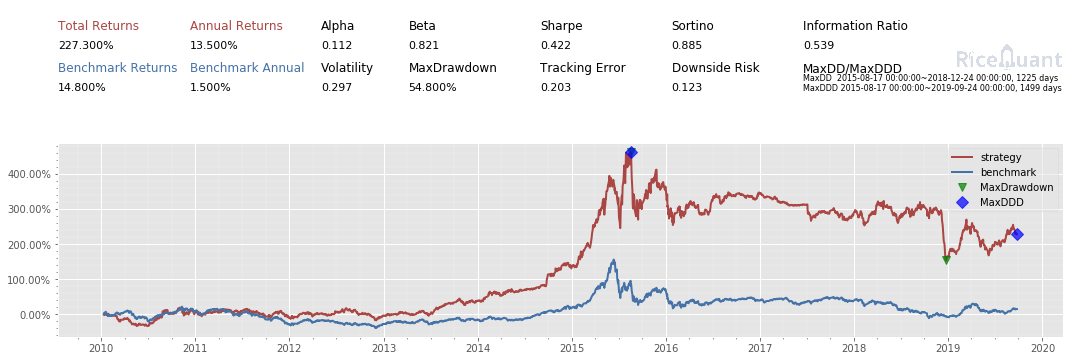

In [6]:
%matplotlib inline
tune_record  = tune_record.rename(columns={'weight':'portfolio_weight'})
# 筛选到权重小的股票
tune_record = tune_record[tune_record['portfolio_weight'] >= 0.05]
result = ricequant_backtesting(tune_record[['trade_date','code','portfolio_weight']])

# 回测记录

In [7]:
print(result.keys())
record = result['sys_analyser']
print(record.keys())
trade_detail = record['trades']
stock_account = record['stock_account']
stock_positions = record['stock_positions']

2019-09-24 INFO dict_keys(['sys_analyser'])
2019-09-24 INFO dict_keys(['summary', 'trades', 'portfolio', 'benchmark_portfolio', 'stock_account', 'stock_positions'])


## 回测曲线

In [8]:
def max_ddd(arr):
    max_seen = arr[0]
    ddd_start, ddd_end = 0, 0
    ddd = 0
    start = 0
    in_draw_down = False

    for i in range(len(arr)):
        if arr[i] > max_seen:
            if in_draw_down:
                in_draw_down = False
                if i - start > ddd:
                    ddd = i - start
                    ddd_start = start
                    ddd_end = i - 1
            max_seen = arr[i]
        elif arr[i] < max_seen:
            if not in_draw_down:
                in_draw_down = True
                start = i - 1

    if arr[i] < max_seen:
        if i - start > ddd:
            return start, i

    return ddd_start, ddd_end

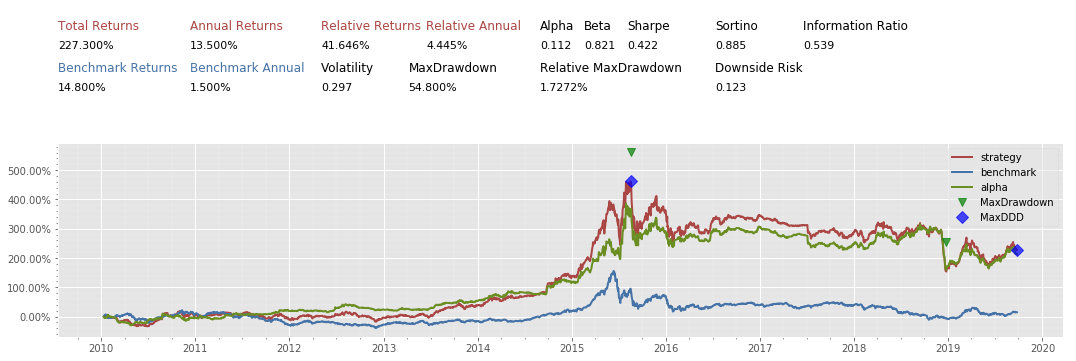

In [9]:
from matplotlib import rc
from matplotlib import pyplot as plt
from matplotlib import rcParams, gridspec, ticker, image as mpimg, pyplot as plt
from matplotlib.font_manager import findfont, FontProperties
import plotly.offline as py
import plotly.graph_objs as go

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = [
        u'Microsoft Yahei',
        u'Heiti SC',
        u'Heiti TC',
        u'STHeiti',
        u'WenQuanYi Zen Hei',
        u'WenQuanYi Micro Hei',
        u"文泉驿微米黑",
        u'SimHei',
    ] + rcParams['font.sans-serif']
rcParams['axes.unicode_minus'] = False

use_chinese_fonts = True
font = findfont(FontProperties(family=['sans-serif']))
if "/matplotlib/" in font:
    use_chinese_fonts = False

title = 'backTestResult'
summary = record["summary"]
portfolio = record["portfolio"]
benchmark_portfolio = record.get("benchmark_portfolio")
index = portfolio.index
portfolio_value = portfolio.unit_net_value * portfolio.units
xs = portfolio_value.values
rt = portfolio.unit_net_value.values
max_dd_end = np.argmax(np.maximum.accumulate(xs) / xs)
if max_dd_end == 0:
    max_dd_end = len(xs) - 1
max_dd_start = np.argmax(xs[:max_dd_end]) if max_dd_end > 0 else 0

max_ddd_start_day, max_ddd_end_day = max_ddd(xs)
max_dd_info = "MaxDD  {}~{}, {} days".format(index[max_dd_start], index[max_dd_end],
                                                 (index[max_dd_end] - index[max_dd_start]).days)
max_dd_info += "\nMaxDDD {}~{}, {} days".format(index[max_ddd_start_day], index[max_ddd_end_day],
                                                    (index[max_ddd_end_day] - index[max_ddd_start_day]).days)
plt.style.use('ggplot')
red = "#aa4643"
blue = "#4572a7"
black = "#000000"
green = "#6B8E23"

plots_area_size = 0
if "plots" in result:
    plots_area_size = 5
    
figsize = (18, 6 + int(plots_area_size * 0.9))
plt.figure(title, figsize=figsize)
max_height = 10 + plots_area_size
gs = gridspec.GridSpec(max_height, 8)

ax = plt.subplot(gs[:3, -1:])
ax.axis("off")   
ax.autoscale_view()

font_size = 12
value_font_size = 11
label_height, value_height = 0.8, 0.6
label_height2, value_height2 = 0.35, 0.15

portfolio_value = portfolio.unit_net_value * portfolio.units
portfolio_df = pd.DataFrame(portfolio_value)
max_values = 0 
pvmax_dd = []
for k, v in portfolio_df.iterrows():
    max_values = max(v.values[0],max_values)
    dd = (v.values[0] - max_values) / max_values
    pvmax_dd.append(dd)
    
benchmark_value = benchmark_portfolio.unit_net_value * portfolio.units
benchmark_df = pd.DataFrame(benchmark_value)
max_values = 0 
bvmax_dd = []
for k, v in benchmark_df.iterrows():
    max_values = max(v.values[0],max_values)
    dd = (v.values[0] - max_values) / max_values
    bvmax_dd.append(dd)
rmdd = abs(np.array(pvmax_dd).min() - np.array(bvmax_dd).min()) / 6

def _(txt):
    return gettext(txt) if use_chinese_fonts else txt


#相对收益及年化收益
relative_value = np.power(1 + record['summary']['annualized_returns'],3) - np.power(
    1 + record['summary']['benchmark_annualized_returns'],3)
relative_annual = relative_value / len(record['stock_account'].index)* 252

fig_data = [
        (0.00, label_height, value_height, _(u"Total Returns"), "{0:.3%}".format(
                    summary["total_returns"]), red, black),
        (0.15, label_height, value_height, _(u"Annual Returns"), "{0:.3%}".format(
                    summary["annualized_returns"]), red, black),
        
        (0.30, label_height, value_height, _(u"Relative Returns"), "{0:.3%}".format(
                    relative_value), red, black),
        (0.42, label_height, value_height, _(u"Relative Annual"), "{0:.3%}".format(
                    relative_annual), red, black),
    
        (0.55, label_height, value_height, _(u"Alpha"), "{0:.4}".format(summary["alpha"]), black, black),
        (0.60, label_height, value_height, _(u"Beta"), "{0:.4}".format(summary["beta"]), black, black),
        (0.65, label_height, value_height, _(u"Sharpe"), "{0:.4}".format(summary["sharpe"]), black, black),
        (0.75, label_height, value_height, _(u"Sortino"), "{0:.4}".format(summary["sortino"]), black, black),
        (0.85, label_height, value_height, _(u"Information Ratio"), "{0:.4}".format(
                    summary["information_ratio"]), black, black),

        (0.00, label_height2, value_height2, _(u"Benchmark Returns"), "{0:.3%}".format(
                    summary.get("benchmark_total_returns", 0)), blue,
         black),
        (0.15, label_height2, value_height2, _(u"Benchmark Annual"), "{0:.3%}".format(
                    summary.get("benchmark_annualized_returns", 0)),
         blue, black),
        (0.30, label_height2, value_height2, _(u"Volatility"), "{0:.4}".format(
                    summary["volatility"]), black, black),
        (0.40, label_height2, value_height2, _(u"MaxDrawdown"), "{0:.3%}".format(
                    summary["max_drawdown"]), black, black),
        (0.55, label_height2, value_height2, _(u"Relative MaxDrawdown"), "{0:.4%}".format(rmdd), black, black),
        (0.75, label_height2, value_height2, _(u"Downside Risk"), "{0:.4}".format(
                    summary["downside_risk"]), black, black),
]

ax = plt.subplot(gs[:3, :-1])
ax.axis("off")

for x, y1, y2, label, value, label_color, value_color in fig_data:
    ax.text(x, y1, label, color=label_color, fontsize=font_size)
    ax.text(x, y2, value, color=value_color, fontsize=value_font_size)
#for x, y1, y2, label, value, label_color, value_color in [
#        (0.85, label_height2, value_height2, _(u"MaxDD/MaxDDD"), max_dd_info, black, black)]:
#    ax.text(x, y1, label, color=label_color, fontsize=font_size)
#    ax.text(x, y2, value, color=value_color, fontsize=8)
    
# strategy vs benchmark
ax = plt.subplot(gs[4:10, :])

ax.get_xaxis().set_minor_locator(ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(ticker.AutoMinorLocator())
ax.grid(b=True, which='minor', linewidth=.2)
ax.grid(b=True, which='major', linewidth=1)


# plot two lines
ax.plot(portfolio["unit_net_value"] - 1.0, label=_(u"strategy"), alpha=1, linewidth=2, color=red)
if benchmark_portfolio is not None:
    ax.plot(benchmark_portfolio["unit_net_value"] - 1.0, label=_(u"benchmark"), alpha=1, linewidth=2, color=blue)
    alpha_portfolio = portfolio["unit_net_value"] - benchmark_portfolio["unit_net_value"]
    ax.plot(alpha_portfolio, label=_(u"alpha"), alpha=1, linewidth=2, color=green)
    
# plot MaxDD/MaxDDD
ax.plot([index[max_dd_end], index[max_dd_start]], [rt[max_dd_end], rt[max_dd_start]],
            'v', color='Green', markersize=8, alpha=.7, label=_(u"MaxDrawdown"))
ax.plot([index[max_ddd_start_day], index[max_ddd_end_day]],
            [rt[max_ddd_start_day] - 1.0, rt[max_ddd_end_day] - 1.0], 'D', color='Blue', markersize=8, alpha=.7,
            label=_(u"MaxDDD"))


# place legend
leg = plt.legend(loc="best")
leg.get_frame().set_alpha(0.5)

# manipulate axis
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.2f}%'.format(x * 100) for x in vals])

if "plots" in record:
    plots_df = result["plots"]
    ax2 = plt.subplot(gs[11:, :])
    for column in plots_df.columns:
        ax2.plot(plots_df[column], label=column)

    leg = plt.legend(loc="best")
    leg.get_frame().set_alpha(0.5)
    
plt.show()

### 模型产生的股票交易指令

In [10]:
tune_record[tune_record['trade_date'] == '2017-03-28 00:00:00']

,portfolio_weight,industry,er,code,dx,trade_date
175158,0.618017,医药生物,0.012469,2399,-0.019019,2017-03-28 00:00:00
175202,0.381899,家用电器,0.011640,2670,-0.159999,2017-03-28 00:00:00


In [11]:
tune_record[tune_record['trade_date'] == '2017-03-26 00:00:00']

,portfolio_weight,industry,er,code,dx,trade_date


### 获取指定交易日期的交易记录


In [12]:
trade_detail[trade_detail['trading_datetime'] == '2017-03-28 15:00:00']

,commission,exec_id,last_price,last_quantity,order_book_id,order_id,position_effect,side,symbol,tax,trading_datetime,transaction_cost
datetime,,,,,,,,,,,,
2017-03-28 15:00:00,225.992,15717297670714,21.73,13000.0,002399.XSHE,15717297672371,OPEN,BUY,海普瑞,0.0,2017-03-28 15:00:00,225.992


In [13]:
trade_detail[trade_detail['trading_datetime'] == '2017-03-06 15:00:00']

,commission,exec_id,last_price,last_quantity,order_book_id,order_id,position_effect,side,symbol,tax,trading_datetime,transaction_cost
datetime,,,,,,,,,,,,


### 获取指定交易日的持仓仓位信息


In [14]:
stock_positions[(stock_positions.index == '2017-03-01') & (stock_positions.quantity != 0)].reset_index()

,date,avg_price,last_price,market_value,order_book_id,quantity,symbol
0,2017-03-01,6.916,7.93,1002986.4,600277.XSHG,126480.0,亿利洁能
1,2017-03-01,7.703,17.62,4434954.0,600363.XSHG,251700.0,联创光电
2,2017-03-01,6.424,20.93,17797197.6,002252.XSHE,850320.0,上海莱士
3,2017-03-01,48.472,16.61,1252726.2,300059.XSHE,75420.0,东方财富
4,2017-03-01,26.020,25.20,18149040.0,002025.XSHE,720200.0,航天电器
5,2017-03-01,19.390,20.40,267240.0,002642.XSHE,13100.0,*ST荣联


In [15]:
stock_positions[(stock_positions.index == '2017-03-06') & (stock_positions.quantity != 0)].reset_index()

,date,avg_price,last_price,market_value,order_book_id,quantity,symbol
0,2017-03-06,6.916,7.83,990338.4,600277.XSHG,126480.0,亿利洁能
1,2017-03-06,7.703,19.42,4888014.0,600363.XSHG,251700.0,联创光电
2,2017-03-06,6.424,20.55,17474076.0,002252.XSHE,850320.0,上海莱士
3,2017-03-06,48.472,16.50,1244430.0,300059.XSHE,75420.0,东方财富
4,2017-03-06,26.020,25.20,18149040.0,002025.XSHE,720200.0,航天电器
5,2017-03-06,19.390,20.96,274576.0,002642.XSHE,13100.0,*ST荣联


In [16]:
# trade_detail.to_csv('./trades_record.csv', encoding="utf_8_sig")